MOUNT THE DRIVE AND LOAD THE DATASET

In [20]:
#save test set predictions to a file
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [21]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

In [22]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "../harmonies_database"

In [23]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls ../harmonies_database

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
analog/  rectangle/


In [25]:
from torch.utils.data import Dataset
import numpy as np

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = torch.Tensor(np.moveaxis(np.array(Image.open(zebra_path)),-1,0)).to(torch.device("cuda:0"))/255
        horse_img = torch.Tensor(np.moveaxis(np.array(Image.open(horse_path)),-1,0)).to(torch.device("cuda:0"))/255


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"analog"),os.path.join(root_data,"rectangle"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'analog')

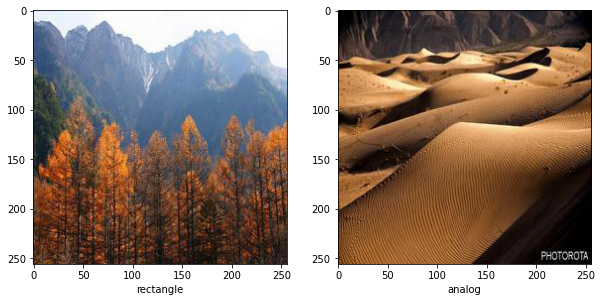

In [26]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.xlabel("analog")

#MODELS

In [27]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [28]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [29]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [30]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [31]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [32]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [33]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[-0.8833, -0.1284, -0.1682,  ..., -0.1830,  0.1671, -0.1834],
         [-0.3355, -0.4065, -0.3438,  ..., -0.1710, -0.2274,  0.0575],
         [-0.5699, -0.0024, -0.0680,  ...,  0.3755, -0.4770, -0.4430],
         ...,
         [ 0.0190, -0.2082,  0.1111,  ..., -0.1529,  0.1295, -0.0217],
         [-0.2308, -0.0116, -0.2468,  ..., -0.1089, -0.1101, -0.0400],
         [-0.0979,  0.2790, -0.2233,  ..., -0.0096, -0.1038,  0.1815]],

        [[-0.6020, -0.0632, -0.5163,  ..., -0.2334,  0.5001,  0.0400],
         [-0.8173, -0.8690, -0.4842,  ..., -0.3850, -0.1304, -0.0563],
         [ 0.3939,  0.2237, -0.4344,  ...,  0.1532,  0.1168,  0.1526],
         ...,
         [-0.4206, -0.1877, -0.3771,  ..., -0.2220, -0.2290, -0.1106],
         [-0.0114,  0.1914,  0.2541,  ..., -0.0386,  0.1114,  0.2617],
         [-0.1522,  0.0297, -0.2970,  ...,  0.0971, -0.0225, -0.2138]],

        [[ 0.6880,  0.3748,  0.6095,  ...,  0.4481,  0.5997,  0.2970],
         [ 0.4197,  0.6076,  0.3722,  ..., -0

In [34]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [35]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
        loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

        #adversarial loss for winter discriminator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
        loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

        #final D loss
        D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


      opt_d.zero_grad()
      D_loss.backward()
      opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_S(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [42]:
disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  3%|▎         | 16/562 [00:01<00:54, 10.02it/s]

Gloss adv :  4.619691848754883 Gloss adv :  0.6252352595329285 D loss :  0.4474472999572754


  6%|▌         | 32/562 [00:03<00:52, 10.19it/s]

Gloss adv :  3.521819829940796 Gloss adv :  0.6738021373748779 D loss :  0.4264816641807556


  8%|▊         | 46/562 [00:04<00:51, 10.00it/s]

Gloss adv :  3.3870017528533936 Gloss adv :  0.6283308267593384 D loss :  0.4575920104980469


 11%|█         | 62/562 [00:06<00:50, 10.00it/s]

Gloss adv :  2.4136805534362793 Gloss adv :  0.7486717104911804 D loss :  0.3276376724243164


 12%|█▏        | 65/562 [00:06<00:49, 10.07it/s]


KeyboardInterrupt: ignored

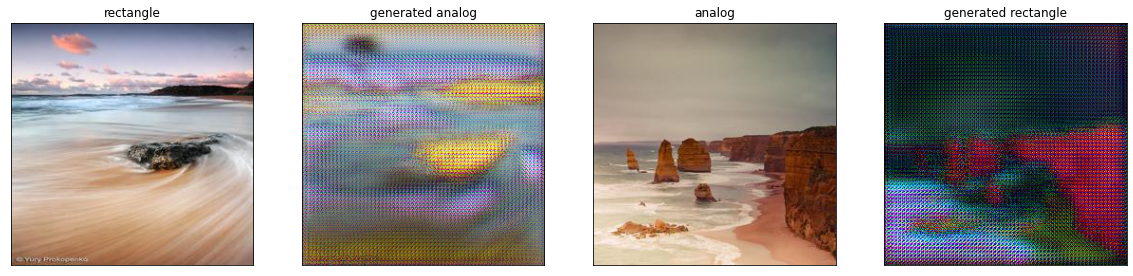

In [43]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("generated analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)